# Import required libaries and dataset:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv('LOG_AAPL_QUARTERLY_FINANCIALDATA.csv')

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['LOG_CLOSE']]
data.dropna(inplace=True)

print(data.head())

            LOG_CLOSE
Date                 
2005-09-24   2.281033
2005-12-31   2.409933
2006-04-01   2.350248
2006-07-01   2.311754
2006-09-30   2.439333


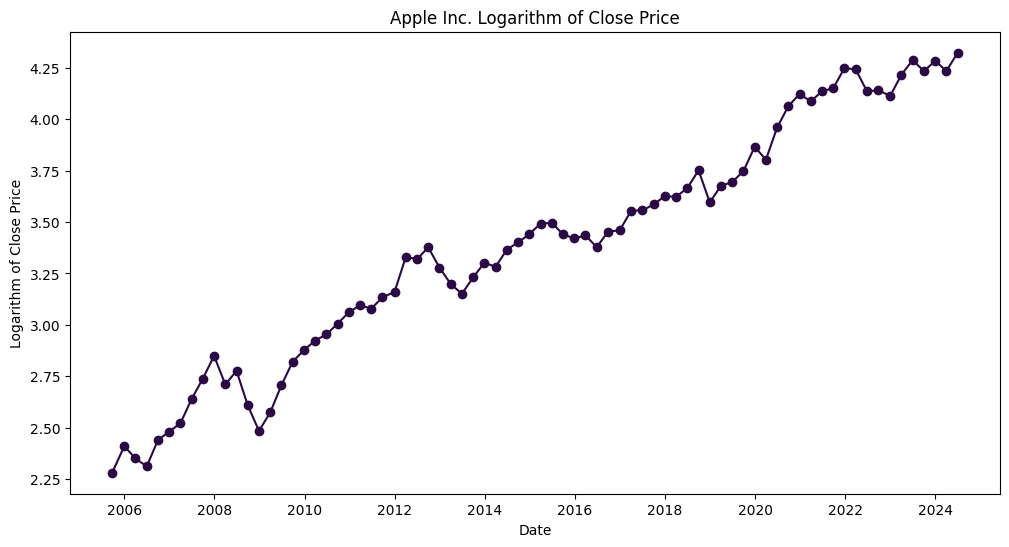

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(data['LOG_CLOSE'],color='#2a0944', marker='o')
plt.title('Apple Inc. Logarithm of Close Price')
plt.xlabel('Date')
plt.ylabel('Logarithm of Close Price')
plt.show()

# Plot the ACF & PACF:

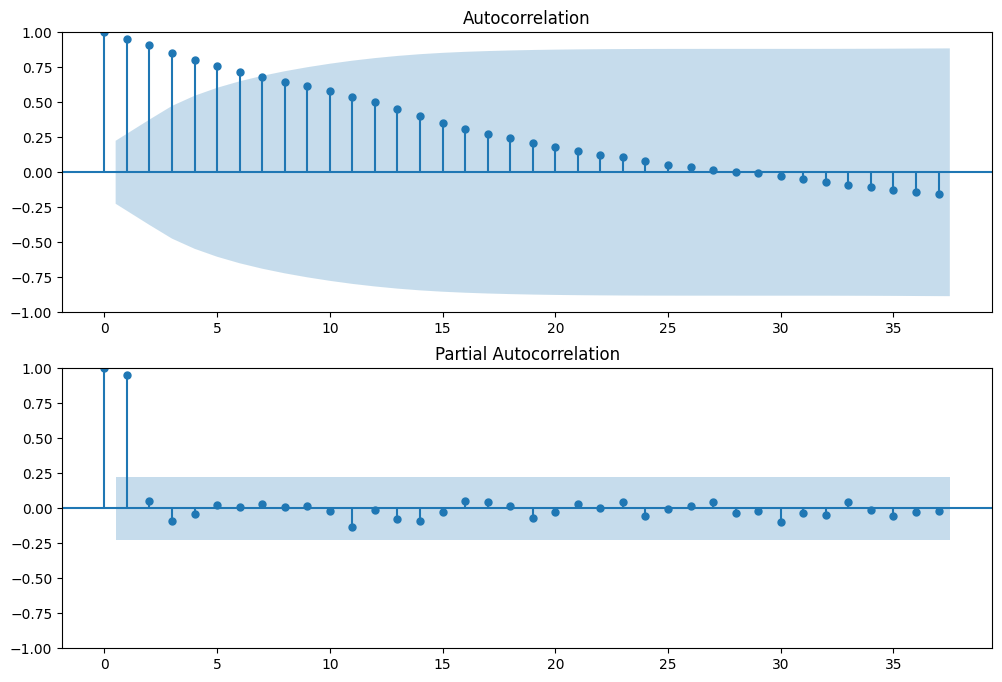

In [4]:
plt.figure(figsize=(12, 8))
plt.subplot(211)
plot_acf(data['LOG_CLOSE'], ax=plt.gca(), lags=37)
plt.subplot(212)
plot_pacf(data['LOG_CLOSE'], ax=plt.gca(), lags=37)
plt.show()

# ADF Test:


Null hypothesis: The series is stationary


Alternative hypothesis: The series is non-stationary

In [5]:
# Run the ADF test to check the stationarity of the time series
result = adfuller(data['LOG_CLOSE'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -1.0049817485470829
p-value: 0.7514429889384124
Critical Values: {'1%': np.float64(-3.520713130074074), '5%': np.float64(-2.9009249540740742), '10%': np.float64(-2.5877813777777776)}


Since the p-value of the ADF test is larger than 0.05, we accept the alternative hypothesis. Therefore, the series is not stationary.


# Differencing the time series:

In [6]:
data['LOG_CLOSE'] = data['LOG_CLOSE'].diff().dropna()
data.dropna(inplace=True)

print(data.head())

            LOG_CLOSE
Date                 
2005-12-31   0.128900
2006-04-01  -0.059685
2006-07-01  -0.038494
2006-09-30   0.127579
2006-12-30   0.042110


# Determine p, q using ACF & PACF:

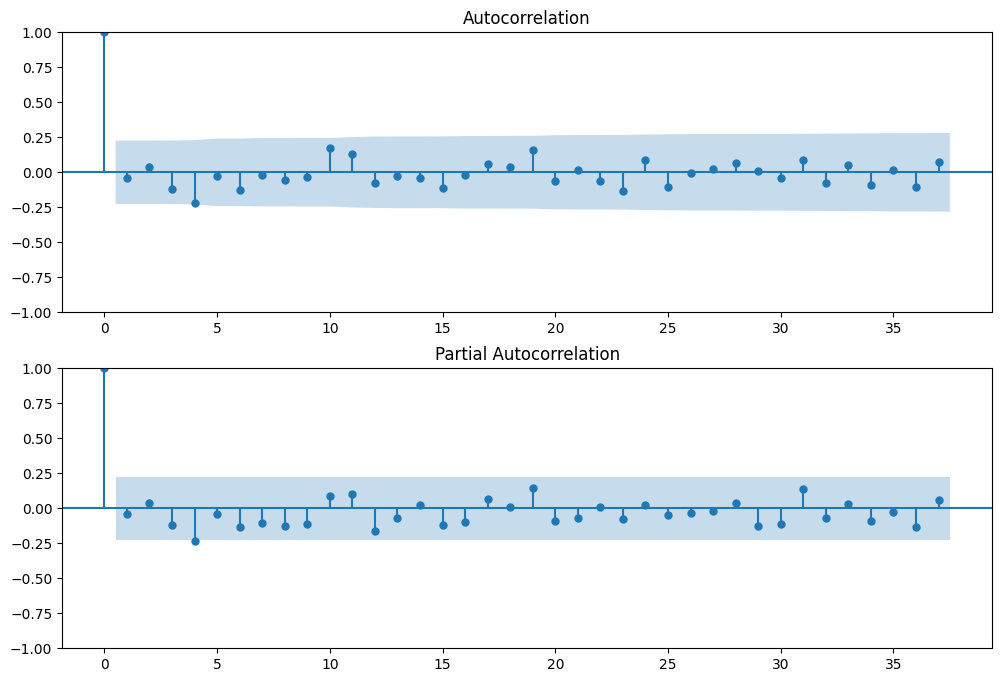

In [7]:
plt.figure(figsize=(12, 8))
plt.subplot(211)
plot_acf(data['LOG_CLOSE'], ax=plt.gca(), lags=37)
plt.subplot(212)
plot_pacf(data['LOG_CLOSE'], ax=plt.gca(), lags=37)
plt.show()

# ADF TEST:


In [8]:
# Run the ADF test to check the stationarity of the time series
result = adfuller(data['LOG_CLOSE'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -5.642549923344537
p-value: 1.0286108877255237e-06
Critical Values: {'1%': np.float64(-3.526004646825607), '5%': np.float64(-2.9032002348069774), '10%': np.float64(-2.5889948363419957)}


After the first differencing, the time series has been stationarized; therefore, further differencing is unnecessary and  d = 1.

# Plot the ARIMA prediction:

                               SARIMAX Results                                
Dep. Variable:              LOG_CLOSE   No. Observations:                   75
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  75.817
Date:                Sun, 17 Nov 2024   AIC                           -145.634
Time:                        07:56:48   BIC                           -138.721
Sample:                             0   HQIC                          -142.876
                                 - 75                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6738      0.108     -6.237      0.000      -0.886      -0.462
ar.L2         -0.2411      0.098     -2.449      0.014      -0.434      -0.048
sigma2         0.0075      0.001      6.499      0.0

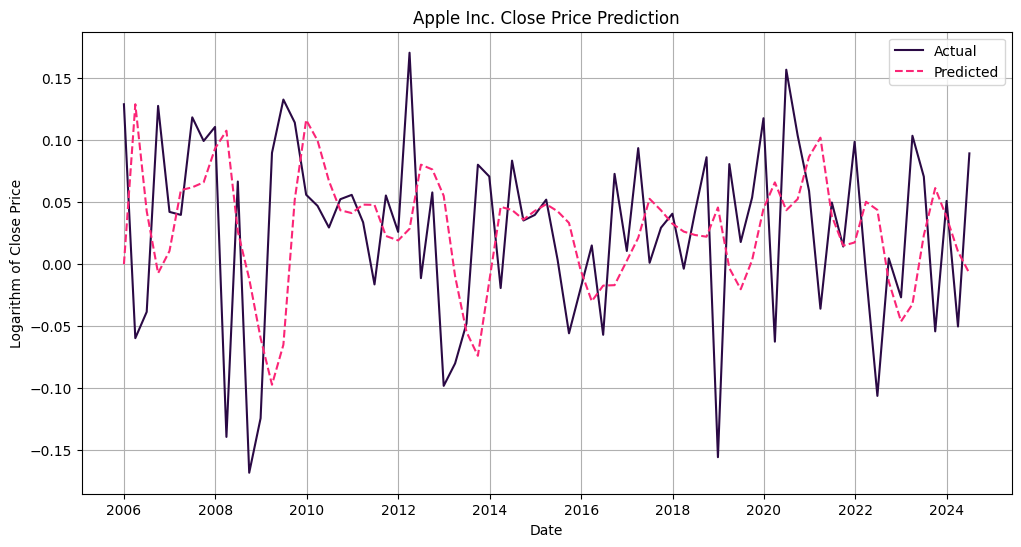

In [9]:
# Define the ARIMA model
model = ARIMA(data['LOG_CLOSE'], order=(2, 1, 0)) 

# Fit the model
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

# Make predictions
predictions = model_fit.predict()

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(data.index,data['LOG_CLOSE'], label='Actual', color='#2A0944')
plt.plot(data.index,predictions, label='Predicted', color='#FB2576', linestyle='--')
plt.title('Apple Inc. Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Logarithm of Close Price')
plt.legend()
plt.grid()
plt.show()

# Evaluate ARIMA model using MAE & RMSE:

In [10]:
# Extract the actual values for the same period
actual = data['LOG_CLOSE']

# Calculate MAE
mae = mean_absolute_error(data['LOG_CLOSE'], predictions)
print('Mean Absolute Error (MAE):', mae)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(data['LOG_CLOSE'], predictions))
print('Root Mean Square Error (RMSE):', rmse)

Mean Absolute Error (MAE): 0.06761330901638418
Root Mean Square Error (RMSE): 0.0882179447795338


# Forecast future close price:

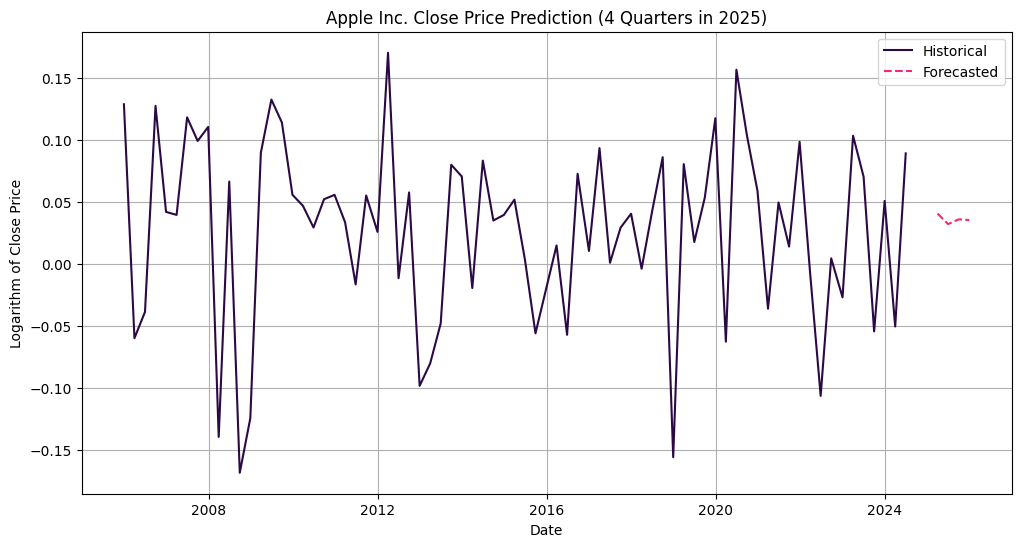

            Forecast_LOG_CLOSE
Date                          
2025-03-31            0.040772
2025-06-30            0.032283
2025-09-30            0.036110
2025-12-31            0.035578


In [11]:
# Prepare the data for forecasting
future_steps = 6 # Forecast 4 quarters starting from 2025 (does not count the 2 last quarters of 2024)
last_date = data.index[-1]

# Generate future dates
future_dates = pd.date_range(start=last_date, periods=future_steps + 1, freq='Q')[1:]

# Fit the ARIMA model again if needed
model = ARIMA(data['LOG_CLOSE'], order=(2, 1, 0))
model_fit = model.fit()

# Forecast future values
forecast = model_fit.forecast(steps=future_steps)

# Combine the forecast results with future dates
forecast_df = pd.DataFrame({'Date': future_dates, 'Forecast_LOG_CLOSE': forecast})
forecast_df.set_index('Date', inplace=True)
forecast_df = forecast_df[2:]

# Plot the historical and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['LOG_CLOSE'], label='Historical', color='#2A0944')
plt.plot(forecast_df.index, forecast_df['Forecast_LOG_CLOSE'], label='Forecasted', color='#FB2576', linestyle='--')
plt.title('Apple Inc. Close Price Prediction (4 Quarters in 2025)')
plt.xlabel('Date')
plt.ylabel('Logarithm of Close Price')
plt.legend()
plt.grid()
plt.show()

# Print forecast results
print(forecast_df)

# Save the forecast results to a CSV file
forecast_df.to_csv('AAPL_4Q2025_FORECAST.csv')